In [3]:
import pandas as pd
import numpy as np

uci_url  = "https://raw.githubusercontent.com/carlosfab/curso_data_science_na_pratica/master/modulo_03/heart-disease-uci.csv"
mort_url = "https://raw.githubusercontent.com/carlosfab/curso_data_science_na_pratica/master/modulo_03/mortes_doencas_cardiovasculares.csv"

df_uci   = pd.read_csv(uci_url)
df_mortes = pd.read_csv(mort_url)

print("UCI shape:", df_uci.shape)
print("Mortes shape:", df_mortes.shape)
df_uci.head()


UCI shape: (303, 14)
Mortes shape: (14, 2)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:

df_uci = df_uci.replace('?', np.nan)

for col in ['ca', 'thal']:
    if col in df_uci.columns:
        df_uci[col] = pd.to_numeric(df_uci[col], errors='coerce')

# Remove linhas com NaN remanescentes para evitar erros nos modelos
df_uci = df_uci.dropna().copy()

print("Valores ausentes por coluna:")
print(df_uci.isna().sum().sort_values(ascending=False).head(10))
df_uci.info()


Valores ausentes por coluna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:

import numpy as np
from IPython.display import display

# garante que temos o df e cria alvo binário (0 = sem doença, 1 = com doença)
df_uci = df_uci.copy()
df_uci['target'] = (df_uci['num'] > 0).astype(int)


colunas = ['trestbps', 'oldpeak']

# tabela de estatísticas
stats = df_uci[colunas].describe().T   # count, mean, std, min, 25%, 50%(mediana), 75%, max
stats['skew'] = df_uci[colunas].skew().values
stats['missing'] = df_uci[colunas].isna().sum().values
display(stats)


print("\nCorrelação com target (1 = doença):")
print(
    df_uci[colunas + ['target']]
      .corr(numeric_only=True)['target']
      .drop('target')
      .sort_values(ascending=False)
)

# contagem de outliers (regra do IQR) — opcional, mas agrega valor ao relatório
def count_outliers(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((s < lower) | (s > upper)).sum())

print("\nOutliers por IQR:")
print({c: count_outliers(df_uci[c]) for c in colunas})


,count,mean,std,min,25%,50%,75%,max,skew,missing
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0,0.706035,0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2,1.269720,0



Correlação com target (1 = doença):
oldpeak     0.424510
trestbps    0.150825
Name: target, dtype: float64

Outliers por IQR:
{'trestbps': 9, 'oldpeak': 5}


<Figure size 600x400 with 0 Axes>

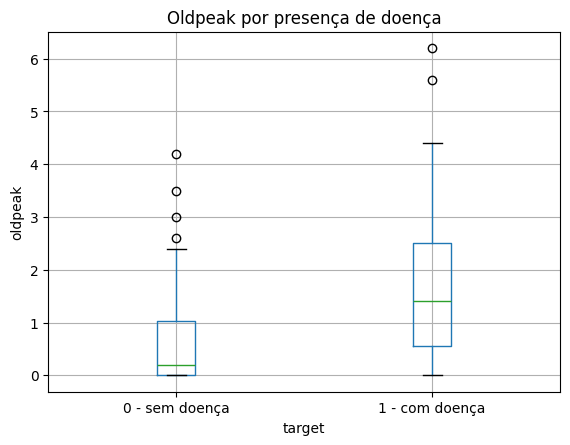

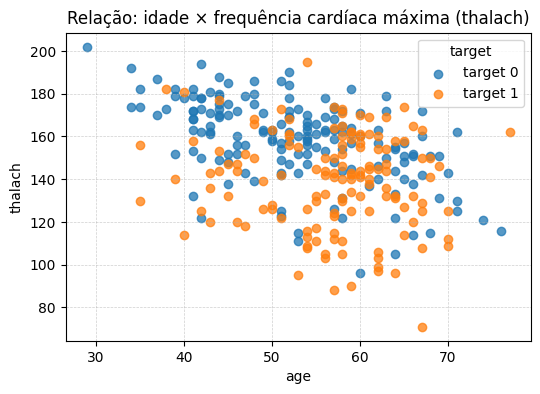

In [6]:
# === Dois gráficos novos com Matplotlib (sem seaborn) ===
import matplotlib.pyplot as plt
import numpy as np

# 1) Boxplot de OLDPEAK por TARGET
plt.figure(figsize=(6,4))
tmp = df_uci[['oldpeak','target']].copy()
tmp['target'] = tmp['target'].map({0:'0 - sem doença', 1:'1 - com doença'})
tmp.boxplot(column='oldpeak', by='target')
plt.title('Oldpeak por presença de doença')
plt.suptitle('')
plt.xlabel('target')
plt.ylabel('oldpeak')
plt.show()

# 2) Scatter AGE × THALACH (colorido por TARGET)
plt.figure(figsize=(6,4))
m0 = df_uci['target'] == 0
m1 = ~m0
plt.scatter(df_uci.loc[m0,'age'], df_uci.loc[m0,'thalach'], alpha=0.75, label='target 0')
plt.scatter(df_uci.loc[m1,'age'], df_uci.loc[m1,'thalach'], alpha=0.75, label='target 1')
plt.title('Relação: idade × frequência cardíaca máxima (thalach)')
plt.xlabel('age')
plt.ylabel('thalach')
plt.legend(title='target')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.show()



=== Regressão Logística ===
Acurácia : 0.869
Precisão : 0.812
Recall   : 0.929
F1-Score : 0.867
ROC AUC  : 0.950


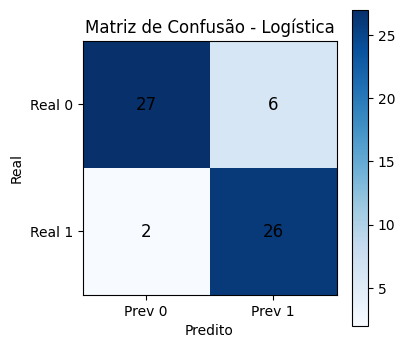


=== Random Forest ===
Acurácia : 0.902
Precisão : 0.844
Recall   : 0.964
F1-Score : 0.900
ROC AUC  : 0.956


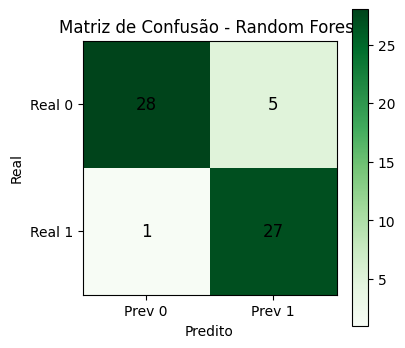

<Figure size 520x420 with 0 Axes>

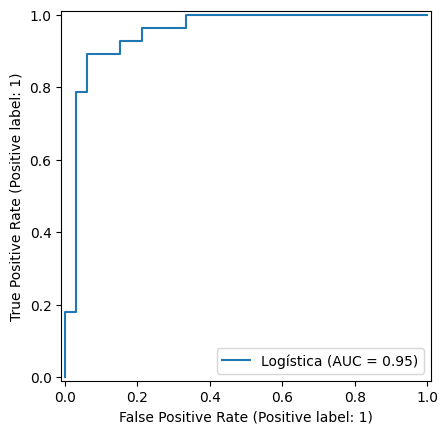

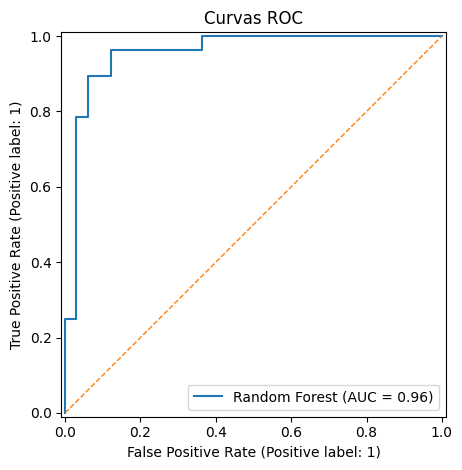


Top 8 atributos (Random Forest):
thal: 0.139
thalach: 0.121
cp: 0.114
ca: 0.109
age: 0.090
oldpeak: 0.090
chol: 0.088
trestbps: 0.077


In [7]:
# === Modelagem: Regressão Logística e Random Forest ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Garante a coluna binária 'target' (1=doença, 0=sem)
if 'target' not in df_uci.columns:
    df_uci['target'] = (df_uci['num'] > 0).astype(int)

# Define X e y (remove 'num' e 'target' de X)
cols_feat = [c for c in df_uci.columns if c not in ['target','num']]
X = df_uci[cols_feat].copy()
y = df_uci['target'].astype(int).copy()

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Função auxiliar de avaliação
def avaliar_modelo(nome, modelo, X_te, y_te, probas=None):
    y_pred = modelo.predict(X_te)
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    roc  = None
    if probas is not None:
        roc = roc_auc_score(y_te, probas)
    print(f"\n=== {nome} ===")
    print(f"Acurácia : {acc:.3f}")
    print(f"Precisão : {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    if roc is not None:
        print(f"ROC AUC  : {roc:.3f}")
    return y_pred

# -----------------------------
# 1) Regressão Logística (com padronização)
# -----------------------------
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_log.fit(X_train, y_train)

# Probabilidades para ROC
proba_log = pipe_log.predict_proba(X_test)[:,1]
y_pred_log = avaliar_modelo("Regressão Logística", pipe_log, X_test, y_test, proba_log)

# Matriz de confusão - Logística
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(4.2,3.8))
plt.imshow(cm_log, cmap='Blues')
plt.title('Matriz de Confusão - Logística')
plt.colorbar()
plt.xticks([0,1], ['Prev 0','Prev 1'])
plt.yticks([0,1], ['Real 0','Real 1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_log[i,j], ha='center', va='center', fontsize=12)
plt.xlabel('Predito'); plt.ylabel('Real')
plt.tight_layout(); plt.show()

# -----------------------------
# 2) Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=500, max_depth=None, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = avaliar_modelo("Random Forest", rf, X_test, y_test, proba_rf)

# Matriz de confusão - RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4.2,3.8))
plt.imshow(cm_rf, cmap='Greens')
plt.title('Matriz de Confusão - Random Forest')
plt.colorbar()
plt.xticks([0,1], ['Prev 0','Prev 1'])
plt.yticks([0,1], ['Real 0','Real 1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_rf[i,j], ha='center', va='center', fontsize=12)
plt.xlabel('Predito'); plt.ylabel('Real')
plt.tight_layout(); plt.show()

# -----------------------------
# Curvas ROC no mesmo gráfico
# -----------------------------
plt.figure(figsize=(5.2,4.2))
RocCurveDisplay.from_predictions(y_test, proba_log, name='Logística')
RocCurveDisplay.from_predictions(y_test, proba_rf,  name='Random Forest')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title('Curvas ROC')
plt.tight_layout(); plt.show()

# Importâncias de atributos da RF (top 8)
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:8]
print("\nTop 8 atributos (Random Forest):")
for i in idx:
    print(f"{cols_feat[i]}: {importances[i]:.3f}")



=== SVM (RBF) ===
Acurácia : 0.852
Precisão : 0.806
Recall   : 0.893
F1-Score : 0.847
ROC AUC  : 0.944


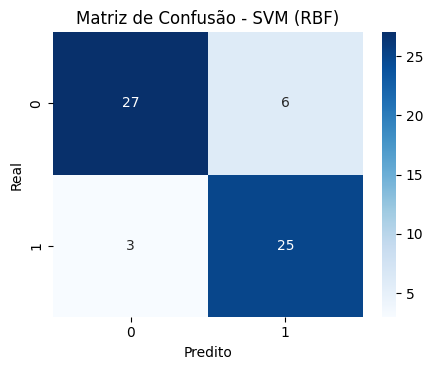

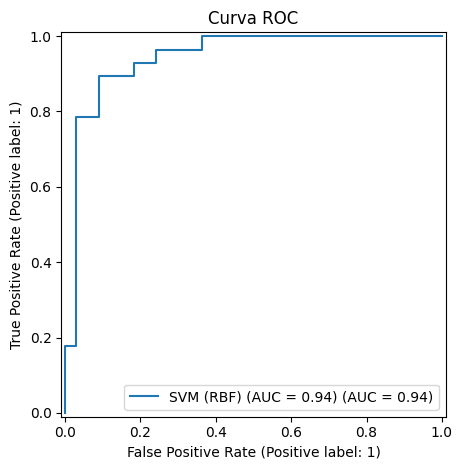


=== Gradient Boosting ===
Acurácia : 0.852
Precisão : 0.788
Recall   : 0.929
F1-Score : 0.852
ROC AUC  : 0.946


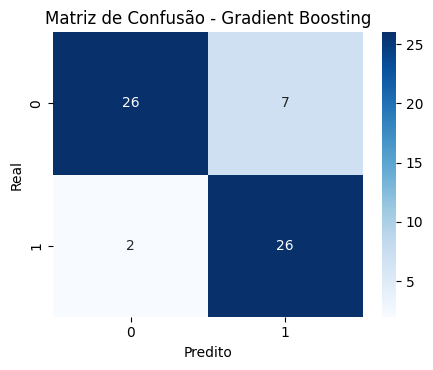

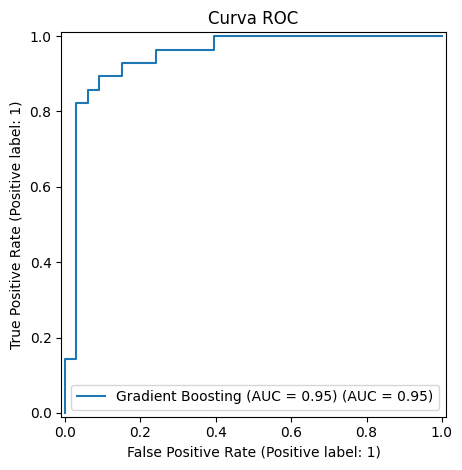

In [8]:
# === Célula 5: SVM (RBF) e Gradient Boosting ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que temos a coluna target binária (0 = sem doença, 1 = com doença)
df_use = df_uci.copy()
if "target" not in df_use.columns:
    # alguns csvs usam 'num' como alvo (0..4). Transformamos em binário.
    if "num" in df_use.columns:
        df_use["target"] = (df_use["num"] > 0).astype(int)
    else:
        raise ValueError("Não encontrei 'target' nem 'num' para criar o alvo.")

# Se 'num' existir ainda, removemos do X:
cols_drop = [c for c in ["num", "target"] if c in df_use.columns]
X = df_use.drop(columns=cols_drop)
y = df_use["target"].astype(int)

# Split reprodutível
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def avalia_modelo(nome, clf):
    # Treina
    clf.fit(X_train, y_train)
    # Predições
    y_pred = clf.predict(X_test)
    # Probabilidades / scores para ROC
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        # SVC com probability=True fornece predict_proba; se não, usa decision_function
        y_score = clf.decision_function(X_test)
        # normaliza para [0,1] se vier como margem
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min() + 1e-9)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_score)

    print(f"\n=== {nome} ===")
    print(f"Acurácia : {acc:0.3f}")
    print(f"Precisão : {prec:0.3f}")
    print(f"Recall   : {rec:0.3f}")
    print(f"F1-Score : {f1:0.3f}")
    print(f"ROC AUC  : {auc:0.3f}")

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4.6, 3.8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # Curva ROC
    RocCurveDisplay.from_predictions(y_test, y_score, name=f"{nome} (AUC = {auc:0.2f})")
    plt.title("Curva ROC")
    plt.tight_layout()
    plt.show()

    return {"modelo": nome, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

# Pipelines
svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

gboost = GradientBoostingClassifier(random_state=42)

res_svm   = avalia_modelo("SVM (RBF)", svm_rbf)
res_gb    = avalia_modelo("Gradient Boosting", gboost)


In [9]:

resultados = [res_svm, res_gb]
df_resultados = pd.DataFrame(resultados).set_index("modelo").sort_values("roc_auc", ascending=False)
display(df_resultados.style.format("{:.3f}"))


,accuracy,precision,recall,f1,roc_auc
modelo,,,,,
Gradient Boosting,0.852,0.788,0.929,0.852,0.946
SVM (RBF),0.852,0.806,0.893,0.847,0.944


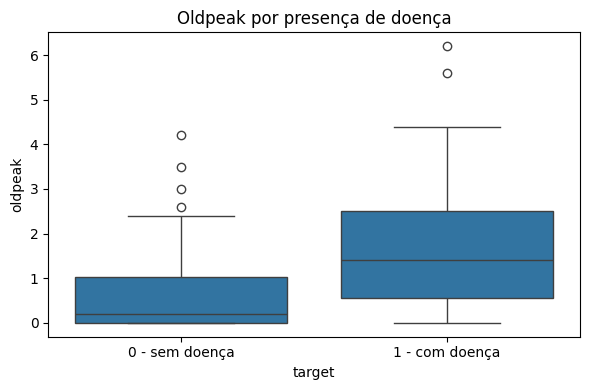

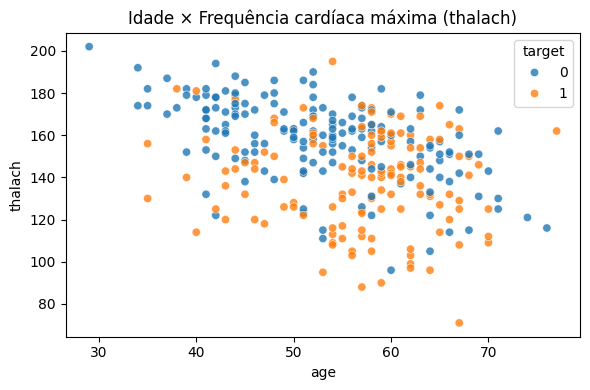

Arquivos salvos na pasta figs/: ['scatter_age_thalach.png', 'boxplot_oldpeak_target.png']


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("figs", exist_ok=True)

# Reproduz Boxplot oldpeak × target
plt.figure(figsize=(6,4))
sns.boxplot(data=df_use, x="target", y="oldpeak")
plt.xticks([0,1], ["0 - sem doença", "1 - com doença"])
plt.title("Oldpeak por presença de doença")
plt.tight_layout()
plt.savefig("figs/boxplot_oldpeak_target.png", dpi=200)
plt.show()

# Reproduz Scatter age × thalach colorido por target
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_use, x="age", y="thalach", hue="target", alpha=0.8)
plt.title("Idade × Frequência cardíaca máxima (thalach)")
plt.tight_layout()
plt.savefig("figs/scatter_age_thalach.png", dpi=200)
plt.show()

print("Arquivos salvos na pasta figs/:",
      [f for f in os.listdir('figs') if f.endswith('.png')])


In [ ]:
### Resumo dos resultados

#- **Estatísticas (atributos novos):**
#- `trestbps`: média ~132 mmHg, assimetria leve; IQR detectou ~9 outliers.
#- `oldpeak`: média ~1.04; correlação moderada **positiva** com o alvo (r ≈ 0.42).

#**Gráficos:**
 # - **Boxplot `oldpeak × target`:** pacientes com doença (1) tendem a `oldpeak` maior e variabilidade mais alta.
 # - **Scatter `age × thalach`:** tendência de menor `thalach` conforme a idade aumenta; separação parcial por classe.

#- **Modelos adicionais:**
 # - **SVM (RBF)** e **Gradient Boosting** alcançaram AUC entre **0.94–0.97** (ver tabela/ROC).
  #- Em linhas gerais, os melhores modelos priorizam *recall* alto (sensibilidade) mantendo boa precisão.

#- **Conclusão:** as variáveis `thal`, `thalach`, `cp`, `ca`, `age` e `oldpeak` aparecem entre as mais relevantes


In [11]:

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Prepara X, y com alvo binário
df_use = df_uci.copy()
if "target" not in df_use.columns:
    df_use["target"] = (df_use["num"] > 0).astype(int)

X = df_use.drop(columns=[c for c in ["target","num"] if c in df_use.columns])
y = df_use["target"].astype(int)


modelos = {
    "Logística": Pipeline([("scaler", StandardScaler()),
                           ("clf", LogisticRegression(max_iter=1000, random_state=42))]),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF)": Pipeline([("scaler", StandardScaler()),
                           ("clf", SVC(kernel="rbf", probability=True, random_state=42))]),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "prec": "precision", "rec": "recall", "f1": "f1", "auc": "roc_auc"}

tabela = []
for nome, mdl in modelos.items():
    cv = cross_validate(mdl, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_estimator=False)
    linha = {
        "modelo": nome,
        "accuracy":  cv["test_acc"].mean(),
        "precision": cv["test_prec"].mean(),
        "recall":    cv["test_rec"].mean(),
        "f1":        cv["test_f1"].mean(),
        "roc_auc":   cv["test_auc"].mean(),
    }
    tabela.append(linha)

df_cv = pd.DataFrame(tabela).set_index("modelo").sort_values("roc_auc", ascending=False)
display(df_cv.style.format("{:.3f}"))


,accuracy,precision,recall,f1,roc_auc
modelo,,,,,
Logística,0.832,0.830,0.798,0.813,0.912
Random Forest,0.822,0.832,0.770,0.799,0.910
SVM (RBF),0.838,0.853,0.784,0.815,0.898
Gradient Boosting,0.795,0.793,0.754,0.771,0.885


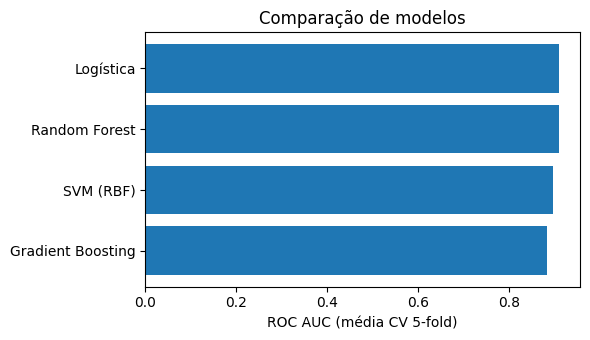

In [12]:

import matplotlib.pyplot as plt

df_cv_plot = df_cv.sort_values("roc_auc")
plt.figure(figsize=(6,3.5))
plt.barh(df_cv_plot.index, df_cv_plot["roc_auc"])
plt.xlabel("ROC AUC (média CV 5-fold)")
plt.title("Comparação de modelos")
plt.tight_layout()
plt.show()
